In [1]:
from typing import List, Any
Shape = Any


In [24]:
from functools import lru_cache
import sys
import os
import glob
import subprocess
import time

import dlib
from scipy.spatial import distance as dist
import cv2
from matplotlib import pyplot
import tqdm.notebook
import ipywidgets as wg
import IPython.core.display
import numpy

from IPython.lib import backgroundjobs

HOME = os.environ['HOME']

In [3]:
jobs = backgroundjobs.BackgroundJobManager()


In [4]:
# If this is broken then patch $VIRTUAL_ENV/lib/python3.7/site-packages/faced/detector.py
# as described in https://github.com/iitzco/faced/issues/27 and then:
#     del sys.modules["faced.detector"]
#     del sys.modules["faced"]
# so that it reloads when you import it again.
# import faced


In [5]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)


In [6]:
@lru_cache(maxsize=1000_000)
def detect(filename) -> List[Shape]:
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)
    shapes = []
    for d in dets:
        shape = predictor(img, d)
        shapes.append(shape)
    return shapes




face_detector = faced.FaceDetector()

def to_rectangles(bboxes):
    rectangles = dlib.rectangles()
    for (x_center, y_center, width, height, prob) in bboxes:
        rectangle = dlib.rectangle(
            x_center - (width//2),
            y_center - (height//2),
            x_center + (width//2),
            y_center + (height//2),
        )
        rectangles.append(rectangle)
    return rectangles

@lru_cache(maxsize=1000_000)
def detect_both_ways(filename):
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)

    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Receives RGB numpy image (HxWxC) and
    # returns (x_center, y_center, width, height, prob) tuples. 
    bboxes = face_detector.predict(rgb_img)
    return dets, to_rectangles(bboxes)



@lru_cache(maxsize=1000_000)
def detect2(filename):
    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    bboxes = face_detector.predict(rgb_img)
    rectangles = to_rectangles(bboxes)
    faces = []
    for d in rectangles:
        face = predictor(img, d)
        if valid(face, img.shape):
            faces.append(face)
    return faces

In [7]:
# see https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
import cv2
import time
import sys


def detectFaceOpenCVDnn(net, frame):
    conf_threshold = 0.8
    
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append((confidence, [x1, y1, x2, y2]))
#             cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
#             cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), 255, int(round(frameHeight/150)), 8)

    return frameOpencvDnn, bboxes

@lru_cache()
def initOpenCVDnn():
    modelFile = "learnopencv/FaceDetectionComparison/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = "learnopencv/FaceDetectionComparison/models/deploy.prototxt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    
    return net

@lru_cache(maxsize=1000_000)
def detect_dnn_with_scores(filename):
    net = initOpenCVDnn()
    img = cv2.imread(filename)
#     rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,img)
    
    faces = []
    for score, bbox in bboxes:
        face = predictor(img, dlib.rectangle(*bbox))
        if valid(face, img.shape):
            faces.append((score, face))
    return faces


def detect_dnn(filename):
    return [face for (_, face) in detect_dnn_with_scores(filename)]

In [8]:
def valid(face, shape=(1920, 3840, 3)):
    y, x, *_channels = shape
    return any((point.x < x and point.y < y) for point in face.parts())

def only_valid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if valid(face, shape)
    ]

def only_invalid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if not valid(face, shape)
    ]

In [9]:
cache = {}
def detect_with_fallbacks(filename):
    shortname = filename.split('/')[-1]
    if 'thumbs-mostviewed' not in filename:
        return detect_dnn(filename)
    elif shortname not in cache:
        cache[shortname] = detect_dnn(filename)
        
    return cache[shortname]


In [10]:
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A =  dlib.length(eye[1] - eye[5])
    B =  dlib.length(eye[2] - eye[4])
 
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dlib.length(eye[0] - eye[3]) or 100000000000000000.0
 
    # compute the eye aspect ratio
    ratio = (A + B) / (2.0 * C)
 
    # return the eye aspect ratio
    return ratio

In [11]:
FACIAL_LANDMARKS_IDXS = dict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 35)),
    ("jaw", (0, 17))
])


if False:
    def eye_aspect_ratio(eye):
        # compute the euclidean distances between the two sets of
        # vertical eye landmarks (x, y)-coordinates
        A =  dlib.length(eye[1] - eye[5])
        B =  dlib.length(eye[2] - eye[4])

        # compute the euclidean distance between the horizontal
        # eye landmark (x, y)-coordinates
        C = dlib.length(eye[0] - eye[3]) or 100000000000000000.0

        # compute the eye aspect ratio
        ratio = (A + B) / (2.0 * C)

        # return the eye aspect ratio
        return ratio

def max_eye_aspect_ratio(faces):
    max_ratio = 0
    for face in faces:
        for part in ("left_eye", "right_eye"):
            start, end = FACIAL_LANDMARKS_IDXS[part]
            eye = face.parts()[start:end]
            ratio = eye_aspect_ratio(eye)
            max_ratio = max([ratio, max_ratio])
    return max_ratio

@lru_cache(maxsize=1000_000)
def eye_score_for_file(filename):
    return max_eye_aspect_ratio(detect_with_fallbacks(filename))

In [12]:
def all_valid(face, shape):
    y, x, *_channels = shape
    return all((0 < point.x < x and 0 < point.y < y) for point in face.parts())

@lru_cache(maxsize=1000_000)
def get_shape(filename):
    net = initOpenCVDnn()
    img = cv2.imread(filename)
    return img.shape

def max_face_size(faces, shape):
    max_size = 0
    for face in faces:
        if not all_valid(face, shape):
            continue
        parts = face.parts()
        size = 0
        size += dlib.length(parts[1] - parts[17])
        size += dlib.length(parts[2] - parts[16])
        size += dlib.length(parts[3] - parts[15])
        max_size = max([size, max_size])
    return max_size

@lru_cache(maxsize=1000_000)
def face_score_for_file(filename):
    (y, x, *_channels) = shape = get_shape(filename)
    return max_face_size(detect_with_fallbacks(filename), shape) / (y + x)
    

In [13]:
def detected_filename(filename):
    return filename\
        .replace('.jpeg', '.jpg')\
        .replace('.jpg', '.detected.jpg')\
        .replace('.jpg.jpg', '.jpg')


@lru_cache(maxsize=1000_000)
def save_face_chip(filename):
    faces = detect_with_fallbacks(filename)
    if not len(faces):
        return filename

    img = dlib.load_rgb_image(filename)
    faces = only_valid(faces, img.shape)
    if not len(faces):
        return filename
    scores = [max_eye_aspect_ratio([face]) for face in faces]

    best_face = max(zip(scores, enumerate(faces)))[-1][-1]
    
    for part in ("left_eye", "right_eye"):
        start, end = FACIAL_LANDMARKS_IDXS[part]
        eye = best_face.parts()[start:end]
        for pointa, pointb in zip(eye, list(eye[1:])+list(eye[:1])):
            cv2.line(img, (pointa.x, pointa.y),(pointb.x, pointb.y), (255,0,255), 5)
#     dlib.save_image(img, filename.replace('.jpeg', '.detected.jpg'))
    dlib.save_face_chip(img, best_face, detected_filename(filename)[:-4])
    return detected_filename(filename)


In [14]:
@lru_cache(maxsize=1000_000)
def save_broken_face_chip(filename):
    faces = only_invalid(detect_with_fallbacks(filename))
    scores = [max_eye_aspect_ratio([face]) for face in faces]
    if len(faces):
        best_face = max(zip(scores, enumerate(faces)))[-1][-1]
        img = dlib.load_rgb_image(filename)
        dlib.save_face_chip(img, best_face, filename.replace('.jpeg', '.jpg').replace('.jpg', '.funky'))
        return filename.replace('.jpeg', '.jpg').replace('.jpg', '.funky.jpg')
    return filename

In [15]:
broken_filenames={}

In [17]:
# faces_folder_path = f'{HOME}/tmp/*x*/*/*.mp4.images/'
faces_folder_path = f'{HOME}/src/eye-tracking/thumbs-mostviewed/*/'

@lru_cache(maxsize=1)
def get_filenames():
    return list(
        f for f in sorted(glob.glob(os.path.join(faces_folder_path, "*.jpg")))
        if '/tmp/3840x1920/1.mp4' not in f
        and 'detected' not in f
        and '.jpg.jpg' not in f
    #     and '1920x1080/1080P_4000K_236777331.mp4' in f
    )

def warm_caches(step=1, smoke=False):
    start = time.time()
    for filename in tqdm.notebook.tqdm(get_filenames()[::step]): #[126:][:1]:
        try:
            shapes = detect_with_fallbacks(filename)
            detect_dnn_with_scores(filename)
            if len(shapes) and 0.5 > eye_score_for_file(filename) > 0.25:
                save_face_chip(filename)
        except (AttributeError, ZeroDivisionError, TypeError, ValueError) as e:
            broken_filenames[filename] = e
        else:
            if smoke and time.time() - start > 10:
                break
           

def warm_caches_backwards():
    warm_caches(-1)
    
warm_caches(smoke=True) 

# jobs.new(warm_caches)
# jobs.new(warm_caches_backwards)


In [51]:
" warm_caches " in str(jobs.running) or jobs.new(warm_caches)
" warm_caches_backwards " in str(jobs.running) or jobs.new(warm_caches_backwards)


<BackgroundJob #3: <function warm_caches_backwards at 0x1218fab00>>

In [19]:
" warm_caches " in str(jobs.running) or jobs.new(warm_caches)
" warm_caches_backwards " in str(jobs.running) or jobs.new(warm_caches_backwards)


True

In [21]:
def get_face_filenames():
    return list(
        sorted(
            [
                filename for filename in get_filenames()
                if True
    #             and ('1920x1080'  in filename)
                and 0.5 > eye_score_for_file(filename) > 0.25 

    #             and '1920x1080/1080P_4000K_236777331.mp4' in filename
    #             and only_invalid(detect_with_fallbacks(filename))
            ],
    #         key=face_score_for_file,
        )
    )

def show_face(x):
    filename = get_face_filenames()[x]
    facename = detected_filename(filename)
    shapes = detect_with_fallbacks(filename)
    print(len(shapes), len(detect(filename)), filename.replace(HOME, '~'))
    print(eye_score_for_file(filename))
    print(face_score_for_file(filename))
    
    if len(shapes):
        print([s for (s,_) in detect_dnn_with_scores(filename)])
        filename = save_face_chip(filename)
    widget = IPython.core.display.Image(filename=filename)
    return widget

# maxf = len(get_face_filenames()) - 1
# wg.interact(show_face, x=(1,maxf));


In [16]:
# len(get_face_filenames()) , len(get_filenames())

(299, 1344)

from collections import Counter
totals_breakdown = Counter(filename.rsplit('/', 1)[0] for filename in get_filenames() )
# totals_breakdown

faces_breakdown = Counter(filename.rsplit('/', 1)[0] for filename in get_face_filenames() )
# faces_breakdown

best = sorted([
        (faces_breakdown[k]/totals_breakdown[k], k.replace('.images/', '.hls/out.m3u8').replace(HOME, '~'))
        for k in totals_breakdown.keys()
        if totals_breakdown[k] > 5
    ], reverse=True)
# best

faces = [
    (filename, face)
    for filename in face_filenames
#         if ('1920x1080/1080P_4000K_236777331.mp4' in filename)
            for face in detect_with_fallbacks(filename)
#                 if not any((point.x < 1920 and point.y < 1080) for point in face.parts())
]


pyplot.figure()
for filename, face in faces:
    points = [
        (point.x, -point.y)
        for point in face.parts()
    ]
    pyplot.scatter(*zip(*points), label=filename.replace(HOME, '~'))
# pyplot.legend()

pyplot.figure()
eyes = [
    (
        eye_score_for_file(filename),
        max((i for (i, _) in detect_dnn_with_scores(filename)), default=0)
    )
    for (i, filename) in enumerate(files)
    if 'Beertje96' in filename
]
pyplot.plot(eyes, linestyle='', marker='.')
pyplot.legend()

In [397]:
# [j.join() for j in jobs.running]

[]

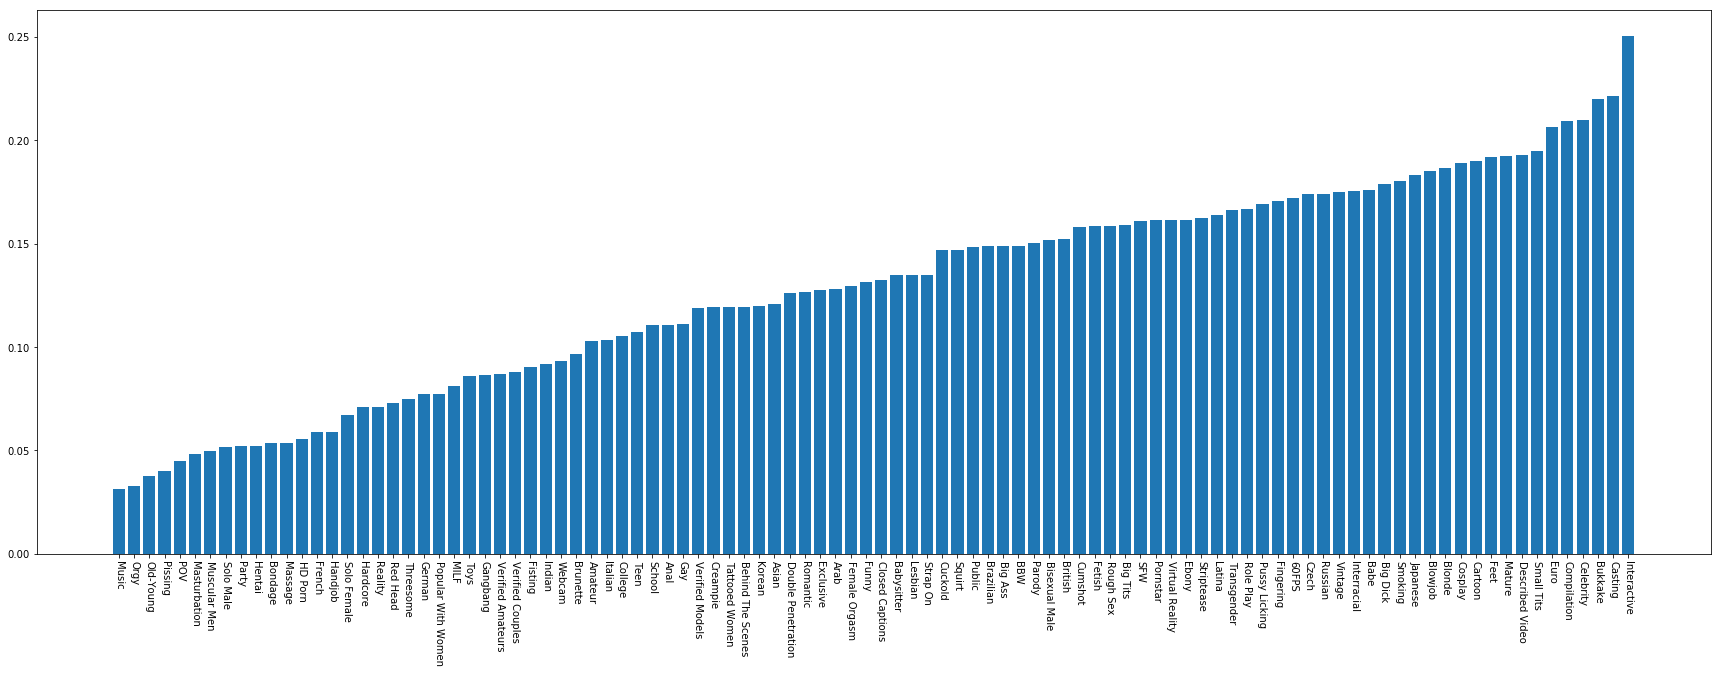

In [164]:
def plot_hits_by_category():
    pyplot.figure(figsize=(30,10))

    totals = []
    faces = []
    labels = []
    to_plot = []
    for folder in glob.glob(faces_folder_path):
        category = folder.rsplit('/')[-2]
    #     print(category)
        total = len([f for f in get_filenames() if folder in f])
        if total > 500:
            totals.append(total)
            face_count = len([f for f in get_face_filenames() if folder in f])
            faces.append(face_count)
            labels.append(category)
            to_plot.append((face_count / total, category))

    height, labels = zip(*sorted(to_plot))
    # bars = labels
    # height = faces
    y_pos = numpy.arange(len(labels))

    # pyplot.scatter(totals, faces)
    pyplot.bar(y_pos, height)
    pyplot.xticks(y_pos, labels, rotation=-90)

plot_hits_by_category()
    

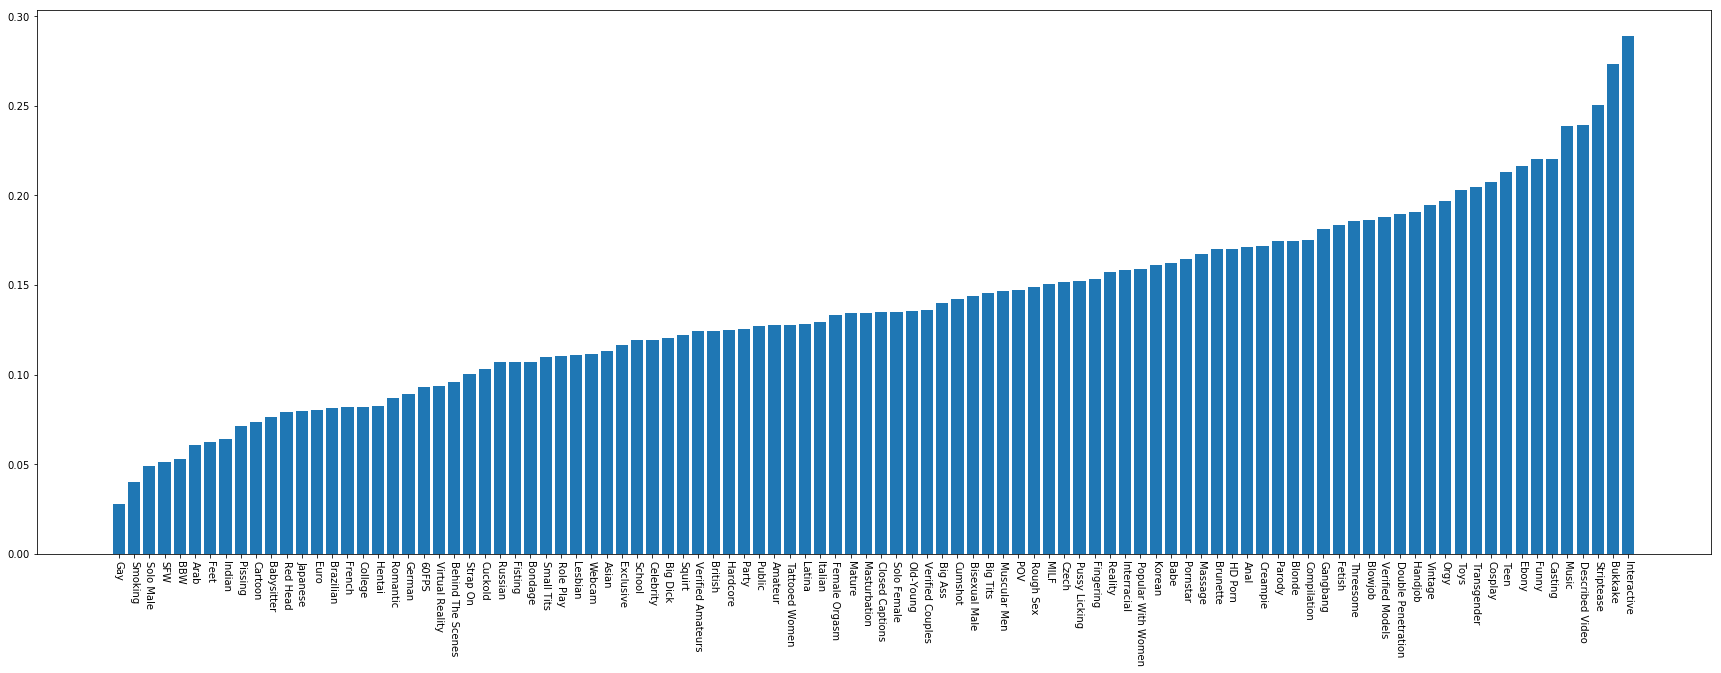

In [234]:
plot_hits_by_category()


In [233]:
def debug_thing():
    totals = []
    faces = []
    labels = []
    to_plot = []
    for folder in glob.glob(faces_folder_path):
        category = folder.rsplit('/')[-2]
    #     print(category)
        total = len([f for f in get_filenames() if folder in f])
        if total < 500:
            print(category, total)
            
debug_thing()


In [58]:
def get_thumbname(url):
    thumbname = url.rsplit('/')[-1]
    return thumbname.rsplit(')', 1)[0] + ')'

def get_hit_per_video_per_category():
    videos_by_category: 'dict[category, dict[videoname, struct[hit, total]]]' = {}
    filenames = get_filenames()
    face_filenames = get_face_filenames()
    
    for filename in get_filenames():
        category = filename.rsplit('/')[-2]
        thumbname = filename.rsplit('/')[-1]
        videoname = thumbname.rsplit(')', 1)[0] + ')'
        videos = videos_by_category.setdefault(category, {})
        counts = videos.setdefault(videoname, {"hit": 0, "total": 0, "sizes": []})
        counts["total"] += 1
        
    for filename in get_face_filenames():
        category = filename.rsplit('/')[-2]
        thumbname = filename.rsplit('/')[-1]
        videoname = thumbname.rsplit(')', 1)[0] + ')'
        videos = videos_by_category.setdefault(category, {})
        counts = videos.setdefault(videoname, {"hit": 0, "total": 0, "sizes": []})
        counts["hit"] += 1
        counts['sizes'].append(face_score_for_file(filename))
    return videos_by_category

def get_stats_per_category():
    stats_by_category = {}
    videos_by_category = get_hit_per_video_per_category()
    for category, videos in videos_by_category.items():
        stats = [
            size / counts["total"]
            for counts in videos.values()
                if counts["total"] > 10
                    for size in counts["sizes"]
        ]
        stats_by_category[category] = stats
#     print(sorted([(t['size'], k) for (k, t) in videos_by_category['Behind The Scenes'].items()]))
        
    stats_by_category = {
        category: values
        for (_, values, category) in
        sorted([
            (numpy.median(values), values, category) for (category, values) in stats_by_category.items()
        ])
    }
    return stats_by_category

def box_plot_of_hit_per_video_per_category():
    fig = pyplot.figure(figsize=(30,10))
    ax = fig.subplots()
    

    stats = get_stats_per_category()
    ax.boxplot(stats.values(), labels=stats.keys())
    locs, labels = pyplot.xticks()
    pyplot.xticks(locs, labels, rotation=-90)
    
    

# box_plot_of_hit_per_video_per_category()

In [22]:
def get_best_videos(category):
    stats = get_hit_per_video_per_category()
    flat = {}
    for cat, videos in stats.items():
        for name, counts in videos.items():
            if counts["total"] > 10 and (category is None or cat == category):
                flat.setdefault(name, []).extend([sum(counts["sizes"]) / counts["total"], cat])
    
    return {
        name: score
        for score, name in 
        sorted(
            ((score, name) for (name, score) in flat.items()),
            reverse=True
        )
    }

# get_best_videos('Behind The Scenes')

In [25]:
import json

@lru_cache(maxsize=1000_000)
def get_length_difference(filename):
    proc = subprocess.run(
        f'ffprobe -v error -show_entries stream -of json {filename}',
        shell=True, check=True, capture_output=True)
    out = json.loads(proc.stdout)
    streams = {stream['codec_type']: stream for stream in out['streams']}
    try:
        video_duration = float(streams['video']["duration"])
        audio_duration = float(streams['audio']["duration"])
    except KeyError:
        return 1.
    return video_duration - audio_duration

get_length_difference(f'{HOME}/tmp/1920x1080/all-videos/ph5c4402553423d.mp4.hls/segment-00016.ts')


0.3170550000000003

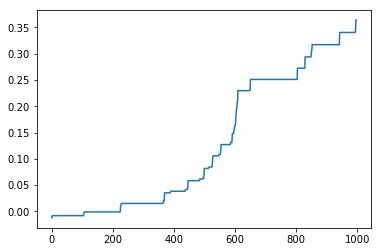

In [29]:
def plot_durations():
    differences = []
#     with open(f'{HOME}/tmp/montage-interleaved-1920x1080-Cosplay.txt') as f:
#         for line in f:
#             filename = line.replace('file ', f'{HOME}/tmp/')
    for filename in tqdm.notebook.tqdm(glob.glob(f'{HOME}/tmp/1920x1080/all-videos/*.hls/*.ts')[:1000]):
        if 'segment-00000.ts' not in filename:
            try:
                differences.append(get_length_difference(filename))
            except Exception as e:
                print(filename.replace(HOME, '~'), e)
    
    pyplot.plot(sorted(differences))

plot_durations()

In [26]:
import sys
'./youtube-dl/' in sys.path or sys.path.append('./youtube-dl/')
import youtube_dl
import youtube_dl.extractor.pornhub as ph

In [75]:
import os

def to_keyframe_filename(ts_filename):
    return ts_filename.strip().replace(
        'segment', 'keyframe'
    ).replace(
        '.hls/', '.images/'
    ).replace(
        '.ts', '.jpeg'
    )

def get_ts_filenames(original_playlist_filename):
    with open(original_playlist_filename) as f:
        lines = iter(list(f))
    
    # take until first #EXTINF
    for line in lines:
        if line.startswith('#EXTINF'):
            break
    
    seen_extinf = True
    files = []
    for line in lines:
        if seen_extinf:
            seen_extinf = False
            
            files.append(
                original_playlist_filename.replace(
                    'out.m3u8', 
                    line.strip()
                )
            )
        elif line.startswith('#EXTINF'):
            seen_extinf = True
        elif line.startswith('#EXT-X-ENDLIST'):
            break
        else:
            print(line)
            raise ValueError(f'{line} does not follow #EXTINF')
    return files
    
def make_filtered_playlist(
    original_playlist_filename,
    filter_function,
    output_filename='filtered.m3u8',
):
    out = []
    chunks: Tuple[str, str] = []
    chunk_start: Optional[str] = None
    with open(original_playlist_filename) as f:
        lines = iter(list(f))

    for line in lines:
        if line.startswith('#EXTINF'):
            chunk_start = line
            break
        out.append(line)

    for line in lines:
        if chunk_start is not None:
            chunks.append((chunk_start, line))
            chunk_start = None
        elif line.startswith('#EXTINF'):
            chunk_start = line
        else:
            # really I should use a peekable iterator, or put line back on
            # the front of lines, but nevermind.
            trailing_line = line
            break
    else:
        trailing_line = ''

    chunks = [
        chunk
        for chunk in chunks
        if filter_function(
            original_playlist_filename.replace(
                '.hls/out.m3u8', 
                '.images/' + to_keyframe_filename(chunk[-1])
            )
        )
    ]

    for chunk in chunks:
        out.extend(chunk)
        # Credit to @DHE in #ffmpeg on freenode for suggesting
        # #EXT-X-DISCONTINUITY.
        # https://developer.apple.com/documentation/http_live_streaming/example_playlists_for_http_live_streaming/incorporating_ads_into_a_playlist
        out.append('#EXT-X-DISCONTINUITY\n')
    # strip the #EXT-X-DISCONTINUITY from after the last chunk
    out.pop()
    out.append(trailing_line)

    for line in lines:
        out.append(line)

    filtered_filename = original_playlist_filename.replace('out.m3u8', output_filename)
    with open(filtered_filename,'w') as f:
        f.write(''.join(out)+'\n')

    concat_filename = original_playlist_filename.replace('out.m3u8', output_filename) + '.txt'
    with open(concat_filename,'w') as f:
        files = [fname for (_, fname) in chunks]
        write_concat_file(concat_filename, files)
    return concat_filename.replace(HOME, '~')
    
def write_concat_file(concat_filename, files):
    dirname = os.path.dirname(concat_filename)
    with open(concat_filename,'w') as f:
        for fname in files:
            f.write(f'file {os.path.relpath(fname.strip(), start=dirname)}\n')
    
def has_eye_contact(filename):
    if not os.path.exists(filename):
        return False
    if 0.25 < eye_score_for_file(filename) < 0.5:
#         print(filename)
#         print(save_face_chip(filename))
        return True
    return False

def has_no_eye_contact(filename):
#     save_face_chip(filename)
    if not os.path.exists(filename):
        return False
    return eye_score_for_file(filename) < 0.25

# for _score, filename in best:
#     print(make_filtered_playlist(
#         filename.replace('~', HOME),
#         has_eye_contact,
#         'filtered.m3u8'
#     ))
#     print(make_filtered_playlist(
#         filename.replace('~', HOME),
#         has_no_eye_contact,
#         'rejected.m3u8'
#     ))

In [77]:
# [has_eye_contact(f) for f in glob.glob(f'{HOME}/tmp/1920x1080/all-videos/ph5c3a8b35b9b84*/keyframe-*.jpeg')]
                

In [103]:
# I think that EXT-X-TARGETDURATION might not actually matter
HEADER = """\
#EXTM3U
#EXT-X-VERSION:3
#EXT-X-TARGETDURATION:3
#EXT-X-MEDIA-SEQUENCE:0
"""
FOOTER = "#EXT-X-ENDLIST\n"

@lru_cache(maxsize=1000_000)
def get_durations(hls_filename) -> 'Dict[str, str]':
    results = {}
    with open(hls_filename) as f:
        lines = iter(f)
        for line in lines:
#             if line.startswith('#EXT-X-TARGETDURATION:'):
#                 if line != '#EXT-X-TARGETDURATION:3\n':
#                     return {}
            if line.startswith('#EXTINF:'):
                duration = line.replace('#EXTINF:', '').replace(',\n', '')
                segment_filename = next(lines)
                results[segment_filename.strip()] = duration
    return results


def get_hls_lines_for_segment(basedir, segment_filename):
    hls_dir = os.path.dirname(segment_filename)
    hls_filename = hls_dir + '/out.m3u8'
    duration = get_durations(hls_filename)[os.path.relpath(segment_filename, start=hls_dir)]
    
    out_segment_filename = os.path.relpath(segment_filename, start=basedir)
    return f'#EXTINF:{duration},\n{out_segment_filename}\n'
        
def write_hls_playlist(output_hls_filename, files):
    dirname = os.path.dirname(output_hls_filename)
    with open(output_hls_filename,'w') as f:
        f.write(HEADER)
        for segment_filename in files:
            try:
                f.write(get_hls_lines_for_segment(dirname, segment_filename))
                f.write('#EXT-X-DISCONTINUITY\n')
            except KeyError:
                pass
        f.write(FOOTER)
        

def collapse_hls_playlist(hls_filename):
    output_filename = hls_filename.replace('.m3u8', '.mpeg')
    pipeline = f"gst-launch-1.0 \
        filesrc location={hls_filename} \
            ! hlsdemux ! tsdemux name=dem \
            ! multiqueue name=queue \
            ! h264parse \
            ! mpegtsmux name=mux ! filesink location={output_filename} \
        dem. ! queue. \
        queue. ! aacparse ! mux."
    
    subprocess.run(pipeline, check=True, shell=True)
    return output_filename
            
print(get_hls_lines_for_segment(HOME, f'{HOME}/tmp/1920x1080/all-videos/ph5c0efef67c779.mp4.hls/segment-00001.ts'))


make_interleaved_montages('Cosplay')


#EXTINF:3.003000,
tmp/1920x1080/all-videos/ph5c0efef67c779.mp4.hls/segment-00001.ts



[('~/tmp/montage-interleaved-1920x1080-Cosplay.concat.mp4',
  '~/tmp/montage-interleaved-1920x1080-Cosplay.mpeg'),
 ('~/tmp/montage-interleaved-1280x720-Cosplay.concat.mp4',
  '~/tmp/montage-interleaved-1280x720-Cosplay.mpeg')]

In [104]:
import subprocess

def download_video(url):
    outfile = f"all-videos/{url.split('viewkey=')[-1]}.mp4"
    if os.path.exists(outfile) or have_expanded_video(outfile):
        return outfile

    ydl = youtube_dl.YoutubeDL({"outtmpl": outfile, "quiet": True})
    ie = ph.PornHubIE(ydl)
    info = ie.extract(url)
#         print([info['formats']])
    selected = sorted([
        (
            f.get('height', -1),
            f.get('format_id', '').count('hls'),
            # python3 refuses to sort dictionaries, so use this to get a stable sort.
            time.monotonic(),
            f
        )
        for f in info['formats']
        # One of the hls manifests is an index, with multple resolutions. Pick one that isn't that.
        if ',' not in f.get('url', ',')
    ])[-1][-1]
    selected['title'] = 'UNUSED_TITLE'
    ydl.process_info(selected)
    return outfile

# def download_video(url):
#     infile = f"all-videos_/{url.split('viewkey=')[-1]}.mp4"
#     outfile = f"all-videos/{url.split('viewkey=')[-1]}.mp4"
#     if os.path.exists(outfile):
#         pass
#     elif os.path.exists(infile):
#         os.rename(infile, outfile)
#     return outfile

def video_lookup_dict(category):
    result = {}
    with open(f'mostviewed/{category}/more-info.txt') as f:
        
        for line in f:
            line = line.strip()
            path, thumb, _count = line.split('§')
            result[get_thumbname(thumb)] = 'https://pornhub.com' + path
    return result        
    
def download_best(category):
    lookup = video_lookup_dict(category)
    best = list(get_best_videos(category).keys())[:10]
    outfiles = []
    for thumbname in best:
        url = lookup[thumbname]
        try:
            outfile = download_video(url)
        except Exception as e:
            if 'Video has been removed' in str(e):
                continue
            else:
                raise
        outfiles.append(outfile)
    return outfiles

def have_expanded_video(downloaded_video_filename):
    return (
        bool(glob.glob(f'{HOME}/tmp/*/{downloaded_video_filename}.images/done'))
        and
        bool(glob.glob(f'{HOME}/tmp/*/{downloaded_video_filename}.hls/done'))
    )

def expand_video(downloaded_video_filename):
    if not have_expanded_video(downloaded_video_filename):
        subprocess.check_call(['./expand-videos.sh', './', f'{HOME}/tmp', downloaded_video_filename])
    thumbdir = glob.glob(f'{HOME}/tmp/*/{downloaded_video_filename}.images')[0]
    
    if have_expanded_video(downloaded_video_filename):
        if os.path.exists(downloaded_video_filename):
            os.remove(downloaded_video_filename)
    else:
        raise ValueError(f'{downloaded_video_filename} did not get split properly')
    return thumbdir.replace('.images', '.hls/out.m3u8')

def filter_expanded(expanded_playlist):
    playlist = make_filtered_playlist(
        expanded_playlist,
        has_eye_contact,
        'filtered.m3u8'
    )
    return playlist

def make_montage(category):
    downloaded = download_best(category)
    playlists = []
    for downloaded_video_filename in downloaded:
        expanded_playlist = expand_video(downloaded_video_filename)
        filtered_playlist = filter_expanded(expanded_playlist)
    
        playlists.append(filtered_playlist) 
    return playlists

def collapse_montage(concat_filename):
    collapsed_filename = concat_filename.replace('.txt', '.concat.mp4')
    if not os.path.exists(collapsed_filename.replace('~', HOME)):
        subprocess.check_call([
            'ffmpeg',
            '-nostdin',
            '-f', 'concat',
            '-i', concat_filename.replace('~', HOME),
            '-c', 'copy',
            '-flags', '+cgop',
            collapsed_filename.replace('~', HOME)
        ])
    return collapsed_filename

def get_queue_from_playlist(input_playlist): # -> Tuple[float, 'filename']:
    segments = get_ts_filenames(input_playlist)
    count = len(segments)
    result = []
    for i, file in enumerate(segments):
#         print(to_keyframe_filename(file))
        if has_eye_contact(to_keyframe_filename(file)):
            result.append((i/count, file))
        
    return result
        
def make_interleaved_montages(category):
    downloaded = download_best(category)
#     print(downloaded)
    queues_by_resolution = {}
    for downloaded_video_filename in downloaded:
#         print(downloaded_video_filename)
        expanded_playlist = expand_video(downloaded_video_filename)
#         print(expanded_playlist)
        resolution = expanded_playlist.split('/tmp/')[1].split('/')[0]
        queues = queues_by_resolution.setdefault(resolution, [])
        queues.append(get_queue_from_playlist(expanded_playlist))
#         print(queues)
    
#     print(sorted([(len(q), res) for (res, q) in queues_by_resolution.items()]))
    montages = []
    for resolution, queues in queues_by_resolution.items():
        files = [file for (_score, file) in sorted(sum(queues, []))]
#         print(resolution, files)

        concat_filename = f'{HOME}/tmp/montage-interleaved-{resolution}-{category}.txt'
        hls_filename = concat_filename.replace('.txt', '.m3u8')
    
        write_concat_file(concat_filename, files)
        write_hls_playlist(hls_filename, files)
        result = (
            collapse_montage(concat_filename).replace(HOME, '~'),
            collapse_hls_playlist(hls_filename).replace(HOME, '~'),
        )
#         print(result)
        montages.append(result)

    return montages
        
# get_queue_from_playlist(f'{HOME}/tmp/1920x1080/all-videos/ph5c3a8b35b9b84.mp4.hls/out.m3u8')

make_montage('Cosplay')
make_interleaved_montages('Cosplay')
# try:
# [make_interleaved_montages(c) for c in cats[:5]]
# except Exception as e:
#     print(e)    
#     raise
# ' && ffplay '.join(make_montage('Striptease'))

[('~/tmp/montage-interleaved-1920x1080-Cosplay.concat.mp4',
  '~/tmp/montage-interleaved-1920x1080-Cosplay.mpeg'),
 ('~/tmp/montage-interleaved-1280x720-Cosplay.concat.mp4',
  '~/tmp/montage-interleaved-1280x720-Cosplay.mpeg')]

In [29]:
1

1

In [30]:

# [print(f"{cat}\nvlc {' '.join([collapse_montage(f) for f in make_montage(cat)])} vlc://quit") for cat in cats[:10]]

In [32]:
# cats


try: 
    [j.join() for j in jobs.running]
finally:
    print('\n'*0)

In [33]:
jobs.running

[<BackgroundJob #0: <function warm_caches at 0x1218fa5f0>>]

In [555]:
float(b'3.103444')

3.103444

In [544]:
cats = list(get_stats_per_category().keys())[:-11:-1]

In [105]:
def make_montages(cats):
    for cat in cats:
        for attempt in range(1, 5):
            print(cat, attempt)
            try:
                make_interleaved_montages(cat)
                break
            except Exception as e:
                print('fail', cat, attempt, e)
        else:
            print("last chance", cat, attempt)
            make_interleaved_montages(cat)

# try:
#     [j.join() for j in jobs.running]
# except Exception:
#     jobs.running or jobs.new(make_montages, cats)
# make_montages(['Transgender', 'Threesome', 'Teen', 'Casting', 'Ebony', 'Toys'])
make_montages(['Cosplay'])

Cosplay 1


In [ ]:
cats


In [519]:
len(cats)

9